**Import Libraries**

In [7]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from bokeh.plotting import figure, show, output_file

**Create Database**

In [8]:
def connect_to_db(db_path):
    """
    Connects to the SQLite database.
    Args:
        db_path (str): Path to the SQLite database file.
    Returns:
        conn: SQLite connection object.
    """
    try:
        conn = sqlite3.connect(db_path)
        print("Connected to database successfully!")
        return conn
    except sqlite3.Error as e:
        print(f"Error connecting to database: {e}")
        return None

def create_tables(conn):
    """
    Creates tables in the SQLite database if they do not already exist.
    Args:
        conn: SQLite connection object.
    """
    try:
        cursor = conn.cursor()
        cursor.executescript('''
            CREATE TABLE IF NOT EXISTS training_data (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                x_value REAL NOT NULL,
                y_value REAL NOT NULL,
                function_id INTEGER NOT NULL
            );

            CREATE TABLE IF NOT EXISTS ideal_functions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                function_name TEXT NOT NULL UNIQUE,
                x_value REAL NOT NULL,
                y_value REAL NOT NULL
            );

            CREATE TABLE IF NOT EXISTS test_data (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                x_value REAL NOT NULL,
                y_value REAL NOT NULL,
                ideal_function_id INTEGER,
                FOREIGN KEY (ideal_function_id) REFERENCES ideal_functions(id)
            );
        ''')
        conn.commit()
        print("Tables created successfully!")
    except sqlite3.Error as e:
        print(f"Error creating tables: {e}")

def insert_training_data(conn, x_value, y_value, function_id):
    """
    Inserts training data into the training_data table.
    Args:
        conn: SQLite connection object.
        x_value (float): X value of the training data.
        y_value (float): Y value of the training data.
        function_id (int): ID of the function associated with the data.
    """
    try:
        cursor = conn.cursor()
        cursor.execute("INSERT INTO training_data (x_value, y_value, function_id) VALUES (?, ?, ?)", (x_value, y_value, function_id))
        conn.commit()
    except sqlite3.Error as e:
        print(f"Error inserting training data: {e}")

def insert_ideal_function(conn, function_name, x_value, y_value):
    """
    Inserts an ideal function into the ideal_functions table if it does not already exist.
    Args:
        conn: SQLite connection object.
        function_name (str): Name of the ideal function.
        x_value (float): X value of the ideal function.
        y_value (float): Y value of the ideal function.
    """
    try:
        cursor = conn.cursor()
        # Check if the function_name already exists
        cursor.execute("SELECT COUNT(*) FROM ideal_functions WHERE function_name = ?", (function_name,))
        count = cursor.fetchone()[0]

        if count == 0:  # If function name does not exist, insert the new function
            cursor.execute("INSERT INTO ideal_functions (function_name, x_value, y_value) VALUES (?, ?, ?)", (function_name, x_value, y_value))
            conn.commit()
            print(f"Ideal function '{function_name}' inserted successfully!")
        else:
            print(f"Ideal function '{function_name}' already exists.")
    except sqlite3.Error as e:
        print(f"Error inserting ideal function: {e}")

def insert_test_data(conn, x_value, y_value, ideal_function_id):
    """
    Inserts test data into the test_data table.
    Args:
        conn: SQLite connection object.
        x_value (float): X value of the test data.
        y_value (float): Y value of the test data.
        ideal_function_id (int): ID of the ideal function associated with the data.
    """
    try:
        cursor = conn.cursor()
        cursor.execute("INSERT INTO test_data (x_value, y_value, ideal_function_id) VALUES (?, ?, ?)", (x_value, y_value, ideal_function_id))
        conn.commit()
    except sqlite3.Error as e:
        print(f"Error inserting test data: {e}")

def fetch_data(conn, table_name):
    """
    Fetches and prints all rows from the specified table.
    Args:
        conn: SQLite connection object.
        table_name (str): Name of the table to fetch data from.
    """
    try:
        cursor = conn.cursor()
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()
        for row in rows:
            print(row)
    except sqlite3.Error as e:
        print(f"Error fetching data from {table_name}: {e}")

def main():
    """
    Main function to demonstrate SQLite operations.
    """
    db_path = "my_database.db"  # Change this to your actual database file
    conn = connect_to_db(db_path)
    if conn:
        create_tables(conn)
        insert_training_data(conn, 1.0, 2.0, 1)
        insert_ideal_function(conn, "f1", 1.0, 2.5)
        insert_ideal_function(conn, "f1", 1.0, 2.5)  # Trying to insert the same function again (won't insert)
        insert_test_data(conn, 1.0, 2.1, 1)
        fetch_data(conn, "training_data")
        fetch_data(conn, "ideal_functions")
        fetch_data(conn, "test_data")
        conn.close()

if __name__ == "__main__":
    main()

Connected to database successfully!
Tables created successfully!
Error inserting training data: table training_data has no column named x_value
Error inserting ideal function: no such column: function_name
Error inserting ideal function: no such column: function_name
Error inserting test data: table test_data has no column named x_value
(-20.0, 39.778572, -40.07859, -20.214268, -0.32491425)
(-19.9, 39.604813, -39.784, -20.07095, -0.058819864)
(-19.8, 40.09907, -40.018845, -19.906782, -0.4518296)
(-19.7, 40.1511, -39.518402, -19.389118, -0.6120442)
(-19.6, 39.795662, -39.360065, -19.81589, -0.3060756)
(-19.5, 39.340855, -38.90581, -19.287113, -0.062154666)
(-19.4, 39.25246, -39.12036, -19.683708, 0.026392838)
(-19.3, 38.590164, -38.62107, -19.494537, -0.2690418)
(-19.2, 38.893463, -38.806778, -19.533716, 0.08567329)
(-19.1, 38.364567, -38.354656, -18.75372, -0.29954198)
(-19.0, 38.13553, -37.795067, -19.363068, -0.553223)
(-18.9, 37.825813, -37.984848, -18.528309, 0.040018722)
(-18.8, 3

**Load Datasets**

In [9]:
# Load Training Data
training_data = pd.read_csv("/content/train.csv")
training_data.to_sql("training_data", engine, if_exists="replace", index=False)

# Load Ideal Functions Data
ideal_functions = pd.read_csv("/content/ideal.csv")
ideal_functions.to_sql("ideal_functions", engine, if_exists="replace", index=False)

# Load Test Data
test_data = pd.read_csv("/content/test.csv")
test_data.to_sql("test_data", engine, if_exists="replace", index=False)



100

**Selection of Ideal Functions**

In [10]:
# Select Four Ideal Functions
selected_ideal_functions = []
for i in range(1, 5):
    min_deviation = float("inf")
    best_function = None
    for col in ideal_functions.columns[1:]:
        deviation = np.sum((training_data[f'y{i}'] - ideal_functions[col])**2)
        if deviation < min_deviation:
            min_deviation = deviation
            best_function = col
    selected_ideal_functions.append(best_function)

**Map Test Data**

In [11]:
# Map Test Data to Ideal Functions
mapping_results = []
for _, row in test_data.iterrows():
    x_val, y_val = row['x'], row['y']
    for func in selected_ideal_functions:
        ideal_y = ideal_functions.loc[ideal_functions['x'] == x_val, func].values
        if len(ideal_y) > 0 and abs(y_val - ideal_y[0]) <= np.sqrt(2):
            mapping_results.append((x_val, y_val, func, abs(y_val - ideal_y[0])))
            break

# Save Mapping Results
mapping_df = pd.DataFrame(mapping_results, columns=["x", "y", "ideal_func", "deviation"])
mapping_df.to_sql("mapping_results", engine, if_exists="replace", index=False)


83

**Visualization**

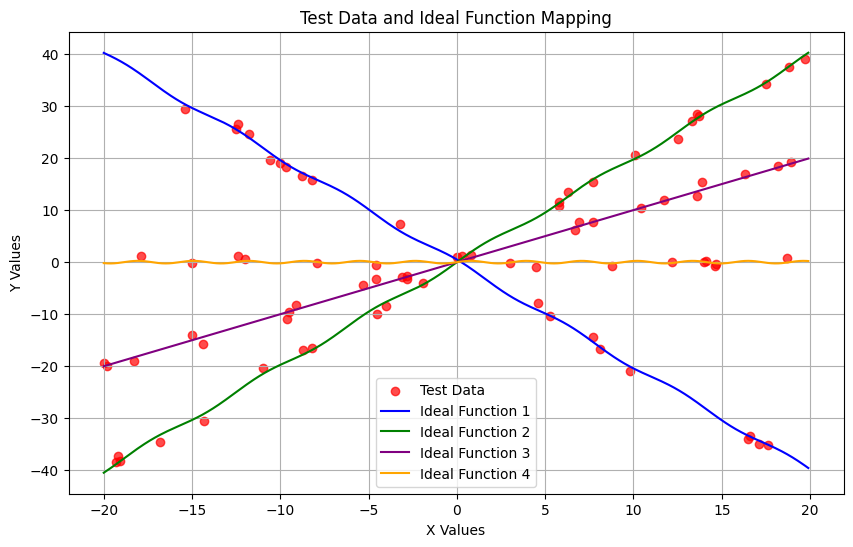

In [12]:

# Visualization
output_file("visualization.html")
p = figure(title="Ideal Function Mapping", x_axis_label='X', y_axis_label='Y')
p.scatter(mapping_df['x'], mapping_df['y'], color="red", legend_label="Test Data")

# Additional Matplotlib Plot
plt.figure(figsize=(10, 6))
plt.scatter(mapping_df['x'], mapping_df['y'], color='red', label='Test Data', alpha=0.7)
colors = ['blue', 'green', 'purple', 'orange']
for idx, func in enumerate(selected_ideal_functions):
    plt.plot(ideal_functions['x'], ideal_functions[func], color=colors[idx], label=f'Ideal Function {idx+1}')

plt.xlabel("X Values")
plt.ylabel("Y Values")
plt.title("Test Data and Ideal Function Mapping")
plt.legend()
plt.grid(True)
plt.show()



**Unit Testing Enhancements**

In [15]:

# Example Test Case for Least Squares Function
def test_least_squares():
    """
    Test case for the least squares function.
    """
    # Mock data
    training_data = pd.DataFrame({'x': [1, 2, 3], 'y1': [1, 4, 9]})
    ideal_functions = pd.DataFrame({'x': [1, 2, 3], 'f1': [1, 4, 9], 'f2': [2, 5, 10]})

    # Expected result
    expected_function = 'f1'

    # Actual result
    selected_function = None
    min_deviation = float("inf")
    for col in ideal_functions.columns[1:]:
        deviation = np.sum((training_data['y1'] - ideal_functions[col])**2)
        if deviation < min_deviation:
            min_deviation = deviation
            selected_function = col

    # Assertion
    assert selected_function == expected_function, f"Expected {expected_function}, got {selected_function}"
    print("Least squares test passed!")

# Run the test
test_least_squares()

Least squares test passed!


**Git Version Control Commands**

In [14]:
print("Git Commands to Clone and Push Changes:")
print("git clone -b develop https://github.com/your_repo.git")
print("cd your_repo")
print("git checkout develop")
print("git add .")
print("git commit -m 'Added SQLite data processing and enhanced visualization' ")
print("git push origin develop")
print("# Create a pull request in GitHub")

# Close Database Connection
conn.close()

Git Commands to Clone and Push Changes:
git clone -b develop https://github.com/your_repo.git
cd your_repo
git checkout develop
git add .
git commit -m 'Added SQLite data processing and enhanced visualization' 
git push origin develop
# Create a pull request in GitHub
